In [8]:
import pandas as pd
from analysis_functions import get_power_data

In [9]:
data_path = "./data_carbontracker/conf-1/power-run3.xls"
power_data = get_power_data(data_path)

In [11]:
# Examine the data structure and basic statistics
print("Data shape:", power_data.shape)
print("\nColumn names:", power_data.columns.tolist())
print("\nFirst few rows:")
print(power_data.head())
print("\nData types:")
print(power_data.dtypes)
print("\nBasic statistics:")
print(power_data.describe())

Data shape: (288, 3)

Column names: ['Date', 'Power(W)', 'Energy(kWh)']

First few rows:
                 Date  Power(W)  Energy(kWh)
1 2025-09-01 11:45:00       224     0.018667
2 2025-09-01 11:50:00       209     0.017417
3 2025-09-01 11:55:00       206     0.017167
4 2025-09-01 12:00:00       203     0.016917
5 2025-09-01 12:05:00       205     0.017083

Data types:
Date           datetime64[ns]
Power(W)                int64
Energy(kWh)           float64
dtype: object

Basic statistics:
                      Date    Power(W)  Energy(kWh)
count                  288  288.000000   288.000000
mean   2025-09-01 23:42:30  229.555556     0.019130
min    2025-09-01 11:45:00  199.000000     0.016583
25%    2025-09-01 17:43:45  202.000000     0.016833
50%    2025-09-01 23:42:30  205.000000     0.017083
75%    2025-09-02 05:41:15  219.250000     0.018271
max    2025-09-02 11:40:00  354.000000     0.029500
std                    NaN   47.499463     0.003958


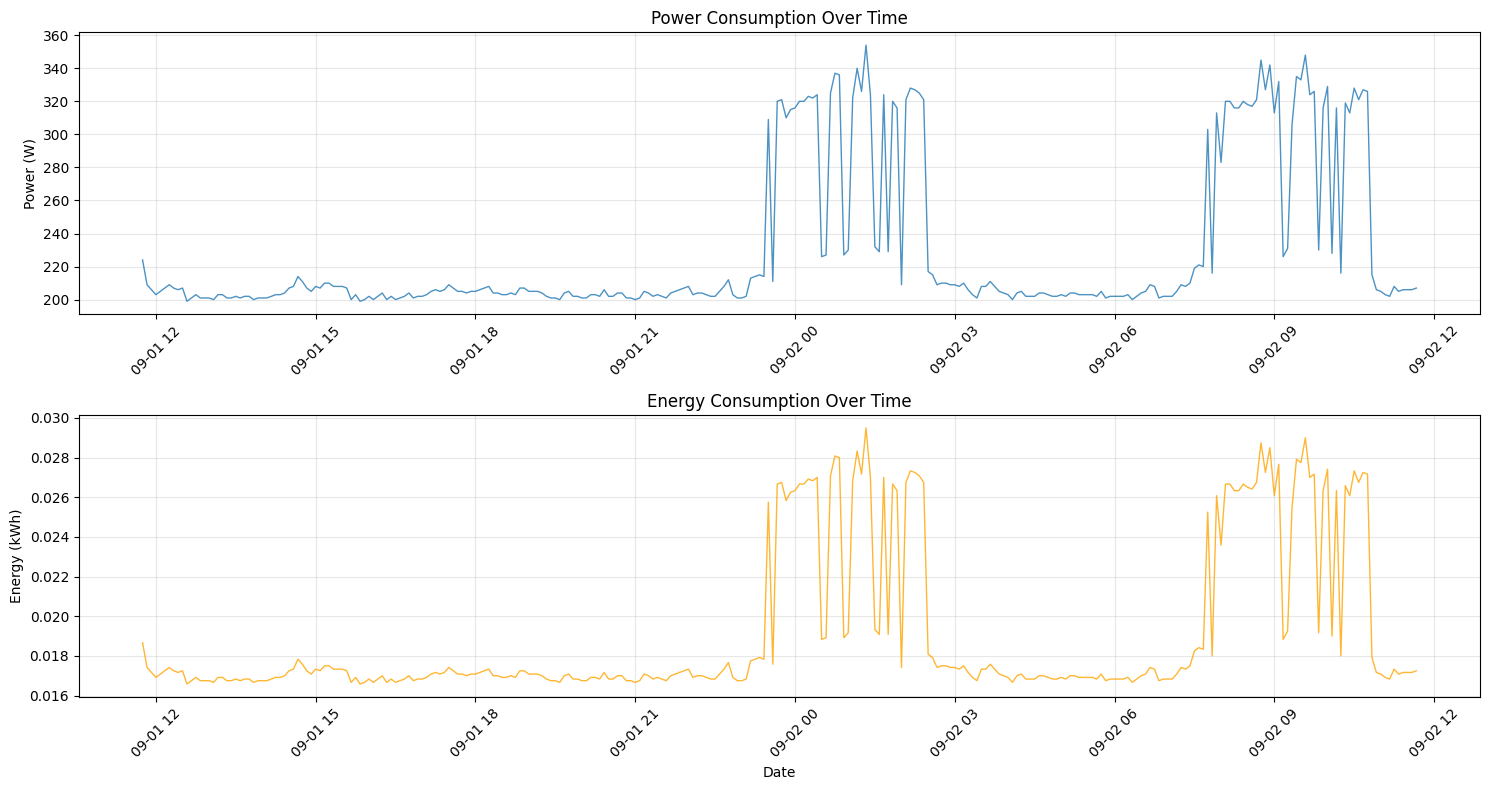

Data spans from 2025-09-01 11:45:00 to 2025-09-02 11:40:00
Total duration: 0 days 23:55:00


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Plot power consumption over time to visualize patterns
plt.figure(figsize=(15, 8))

# Create subplot for power data
plt.subplot(2, 1, 1)
plt.plot(power_data['Date'], power_data['Power(W)'], linewidth=1, alpha=0.8)
plt.title('Power Consumption Over Time')
plt.ylabel('Power (W)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Create subplot for energy data
plt.subplot(2, 1, 2)
plt.plot(power_data['Date'], power_data['Energy(kWh)'], linewidth=1, alpha=0.8, color='orange')
plt.title('Energy Consumption Over Time')
plt.ylabel('Energy (kWh)')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Show time range
print(f"Data spans from {power_data['Date'].min()} to {power_data['Date'].max()}")
print(f"Total duration: {power_data['Date'].max() - power_data['Date'].min()}")

# Power Usage Analysis Plan

Based on the data visualization, I can see there are clear periods of increased power consumption. Here's my comprehensive analysis plan:

## 1. Baseline Power Consumption Analysis
- Identify "quiet" periods with stable, low power consumption
- Calculate baseline statistics (mean, median, std) for these periods
- Determine threshold values for detecting power surges

## 2. Power Surge Detection
- Define threshold criteria for identifying increased power usage periods
- Use statistical methods (e.g., moving averages, percentiles) to detect anomalies
- Implement algorithms to find start/end times of power surge periods

## 3. Time Period Characterization
- For each detected surge period:
  - Start time and end time
  - Duration
  - Peak power consumption
  - Average power during surge
  - Total energy consumed during surge
  - Energy above baseline

## 4. Pattern Analysis
- Frequency of power surges
- Time-of-day patterns
- Duration distribution
- Power level distribution

## 5. Summary Statistics
- Total time in baseline vs. surge states
- Energy consumption breakdown
- Efficiency metrics

In [ ]:
# Step 1: Baseline Power Consumption Analysis

def analyze_baseline_consumption(df, percentile_threshold=75):
    """
    Analyze baseline power consumption by identifying periods with stable, low power usage.

    Parameters:
    df: DataFrame with Date, Power(W), Energy(kWh) columns
    percentile_threshold: Percentile below which we consider power as "baseline"

    Returns:
    dict with baseline statistics
    """
    # Calculate power threshold for baseline (e.g., 75th percentile and below)
    power_threshold = np.percentile(df['Power(W)'], percentile_threshold)

    # Identify baseline periods
    baseline_mask = df['Power(W)'] <= power_threshold
    baseline_data = df[baseline_mask].copy()

    # Calculate baseline statistics
    baseline_stats = {
        'threshold_power': power_threshold,
        'baseline_periods': len(baseline_data),
        'total_periods': len(df),
        'baseline_percentage': len(baseline_data) / len(df) * 100,
        'mean_power': baseline_data['Power(W)'].mean(),
        'median_power': baseline_data['Power(W)'].median(),
        'std_power': baseline_data['Power(W)'].std(),
        'min_power': baseline_data['Power(W)'].min(),
        'max_power': baseline_data['Power(W)'].max(),
        'mean_energy': baseline_data['Energy(kWh)'].mean(),
        'total_baseline_energy': baseline_data['Energy(kWh)'].sum()
    }

    return baseline_stats, baseline_data

# Analyze baseline consumption
baseline_stats, baseline_data = analyze_baseline_consumption(power_data, percentile_threshold=70)

print("=== BASELINE POWER CONSUMPTION ANALYSIS ===")
print(f"Power threshold for baseline: {baseline_stats['threshold_power']:.1f} W")
print(f"Baseline periods: {baseline_stats['baseline_periods']} out of {baseline_stats['total_periods']} ({baseline_stats['baseline_percentage']:.1f}%)")
print(f"Mean baseline power: {baseline_stats['mean_power']:.1f} W")
print(f"Median baseline power: {baseline_stats['median_power']:.1f} W")
print(f"Std baseline power: {baseline_stats['std_power']:.1f} W")
print(f"Power range: {baseline_stats['min_power']:.1f} - {baseline_stats['max_power']:.1f} W")
print(f"Mean baseline energy per period: {baseline_stats['mean_energy']:.6f} kWh")
print(f"Total baseline energy: {baseline_stats['total_baseline_energy']:.4f} kWh")

=== BASELINE POWER CONSUMPTION ANALYSIS ===
Power threshold for baseline: 210.9 W
Baseline periods: 201 out of 288 (69.8%)
Mean baseline power: 204.0 W
Median baseline power: 203.0 W
Std baseline power: 2.7 W
Power range: 199.0 - 210.0 W
Mean baseline energy per period: 0.016998 kWh
Total baseline energy: 3.4167 kWh


In [ ]:
# Step 2: Power Surge Detection

def detect_power_surges(df, baseline_stats, surge_threshold_multiplier=1.2, min_duration_minutes=10):
    """
    Detect periods of increased power usage (surges).

    Parameters:
    df: DataFrame with Date, Power(W), Energy(kWh) columns
    baseline_stats: Dictionary with baseline statistics
    surge_threshold_multiplier: Multiplier above baseline mean to consider as surge
    min_duration_minutes: Minimum duration in minutes to consider as a valid surge period

    Returns:
    List of surge periods with start/end times and statistics
    """
    # Define surge threshold
    surge_threshold = baseline_stats['mean_power'] * surge_threshold_multiplier

    # Identify surge points
    df_copy = df.copy()
    df_copy['is_surge'] = df_copy['Power(W)'] > surge_threshold

    # Find continuous surge periods
    surge_periods = []
    in_surge = False
    surge_start = None
    surge_data = []

    for idx, row in df_copy.iterrows():
        if row['is_surge'] and not in_surge:
            # Start of new surge
            in_surge = True
            surge_start = row['Date']
            surge_data = [row]
        elif row['is_surge'] and in_surge:
            # Continue surge
            surge_data.append(row)
        elif not row['is_surge'] and in_surge:
            # End of surge
            surge_end = surge_data[-1]['Date']
            surge_duration = (surge_end - surge_start).total_seconds() / 60  # minutes

            # Only keep surges longer than minimum duration
            if surge_duration >= min_duration_minutes:
                surge_df = pd.DataFrame(surge_data)
                surge_info = {
                    'start_time': surge_start,
                    'end_time': surge_end,
                    'duration_minutes': surge_duration,
                    'peak_power': surge_df['Power(W)'].max(),
                    'avg_power': surge_df['Power(W)'].mean(),
                    'min_power': surge_df['Power(W)'].min(),
                    'total_energy': surge_df['Energy(kWh)'].sum(),
                    'data_points': len(surge_df),
                    'avg_energy_per_point': surge_df['Energy(kWh)'].mean(),
                    'surge_data': surge_df
                }
                # Calculate energy above baseline
                baseline_energy_equivalent = len(surge_df) * baseline_stats['mean_energy']
                surge_info['energy_above_baseline'] = surge_info['total_energy'] - baseline_energy_equivalent

                surge_periods.append(surge_info)

            # Reset for next potential surge
            in_surge = False
            surge_data = []

    return surge_periods, surge_threshold

# Detect surge periods
surge_periods, surge_threshold = detect_power_surges(power_data, baseline_stats,
                                                   surge_threshold_multiplier=1.03,
                                                   min_duration_minutes=15)

print("=== POWER SURGE DETECTION ===")
print(f"Surge threshold: {surge_threshold:.1f} W")
print(f"Number of surge periods detected: {len(surge_periods)}")
print(f"Minimum duration considered: 15 minutes")
print("\nDetected surge periods:")
for i, surge in enumerate(surge_periods, 1):
    print(f"\nSurge {i}:")
    print(f"  Start: {surge['start_time']}")
    print(f"  End: {surge['end_time']}")
    print(f"  Duration: {surge['duration_minutes']:.1f} minutes")
    print(f"  Peak power: {surge['peak_power']:.1f} W")
    print(f"  Average power: {surge['avg_power']:.1f} W")
    print(f"  Total energy: {surge['total_energy']:.4f} kWh")
    print(f"  Energy above baseline: {surge['energy_above_baseline']:.4f} kWh")

=== POWER SURGE DETECTION ===
Surge threshold: 210.1 W
Number of surge periods detected: 3
Minimum duration considered: 15 minutes

Detected surge periods:

Surge 1:
  Start: 2025-09-01 23:10:00
  End: 2025-09-02 01:55:00
  Duration: 165.0 minutes
  Peak power: 354.0 W
  Average power: 288.0 W
  Total energy: 0.8159 kWh
  Energy above baseline: 0.2380 kWh

Surge 2:
  Start: 2025-09-02 02:05:00
  End: 2025-09-02 02:35:00
  Duration: 30.0 minutes
  Peak power: 328.0 W
  Average power: 293.4 W
  Total energy: 0.1712 kWh
  Energy above baseline: 0.0522 kWh

Surge 3:
  Start: 2025-09-02 07:30:00
  End: 2025-09-02 10:50:00
  Duration: 200.0 minutes
  Peak power: 348.0 W
  Average power: 297.4 W
  Total energy: 1.0162 kWh
  Energy above baseline: 0.3193 kWh


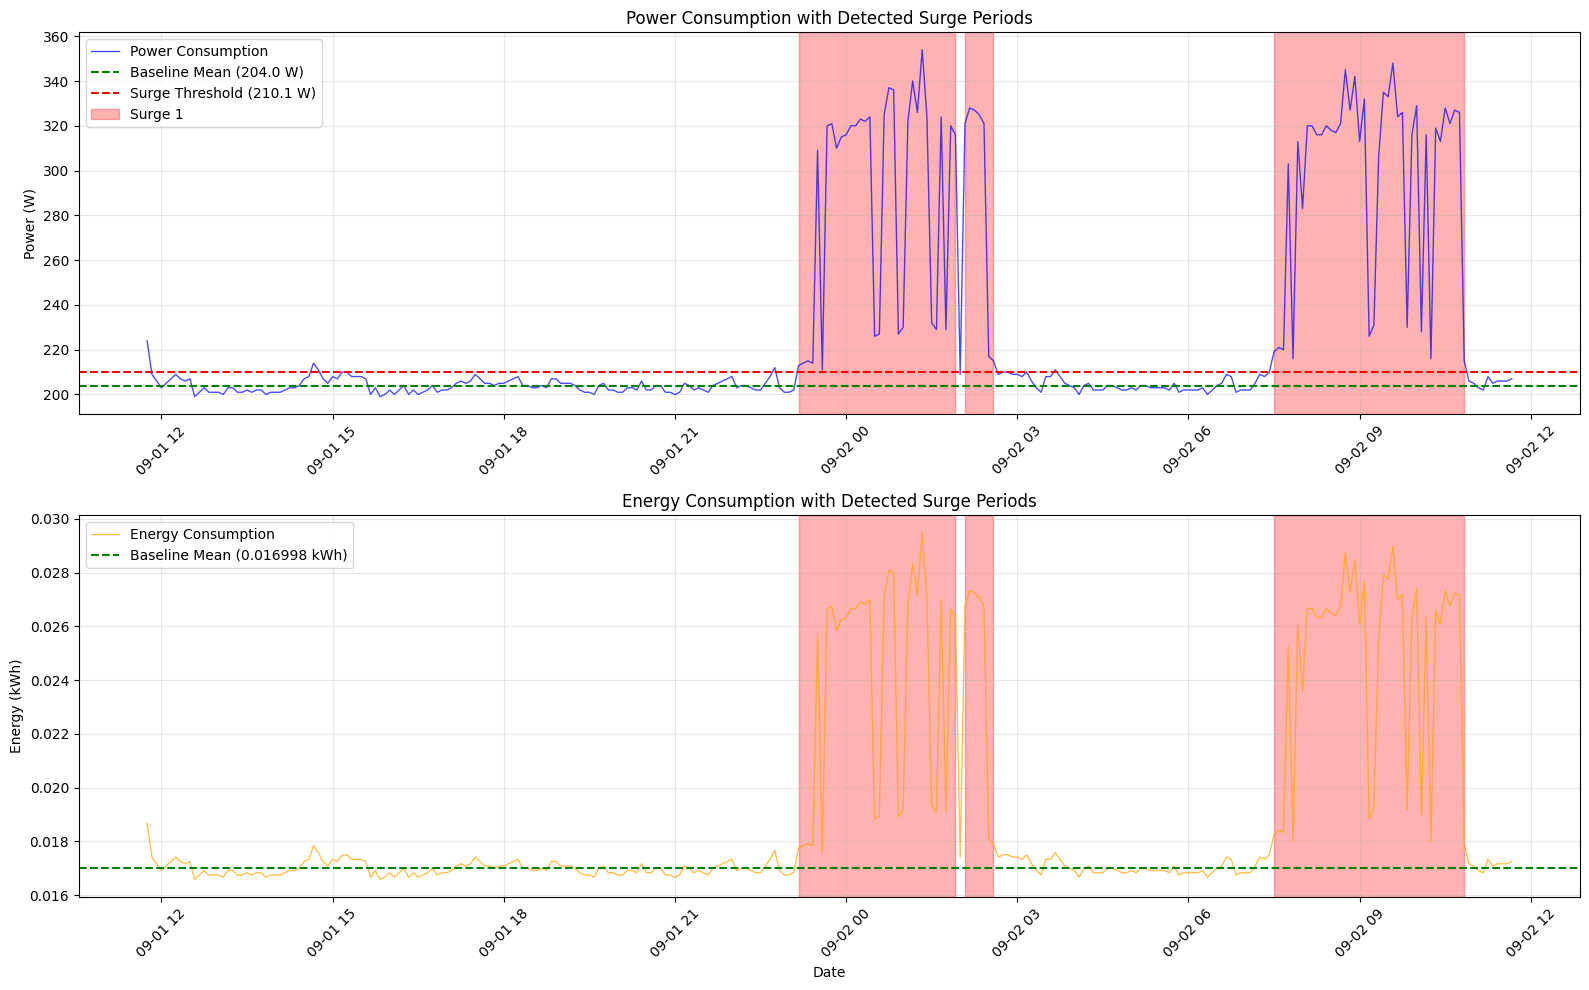

=== SUMMARY STATISTICS ===
Total monitoring period: 1435.0 minutes (23.9 hours)
Time in baseline state: 1040.0 minutes (17.3 hours, 72.5%)
Time in surge state: 395.0 minutes (6.6 hours, 27.5%)

Total energy consumed: 5.5093 kWh
Energy during baseline periods: 3.5060 kWh (63.6%)
Energy during surge periods: 2.0033 kWh (36.4%)
Excess energy above baseline: 0.6095 kWh (11.1%)


In [ ]:
# Step 3: Enhanced Visualization with Surge Periods Highlighted

plt.figure(figsize=(16, 10))

# Main power consumption plot
plt.subplot(2, 1, 1)
plt.plot(power_data['Date'], power_data['Power(W)'], linewidth=1, alpha=0.7, color='blue', label='Power Consumption')

# Add baseline threshold line
plt.axhline(y=baseline_stats['mean_power'], color='green', linestyle='--',
           label=f'Baseline Mean ({baseline_stats["mean_power"]:.1f} W)')
plt.axhline(y=surge_threshold, color='red', linestyle='--',
           label=f'Surge Threshold ({surge_threshold:.1f} W)')

# Highlight surge periods
for i, surge in enumerate(surge_periods):
    plt.axvspan(surge['start_time'], surge['end_time'],
               alpha=0.3, color='red', label=f'Surge {i+1}' if i == 0 else "")

plt.title('Power Consumption with Detected Surge Periods')
plt.ylabel('Power (W)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Energy consumption plot
plt.subplot(2, 1, 2)
plt.plot(power_data['Date'], power_data['Energy(kWh)'], linewidth=1, alpha=0.7, color='orange', label='Energy Consumption')

# Add baseline energy line
plt.axhline(y=baseline_stats['mean_energy'], color='green', linestyle='--',
           label=f'Baseline Mean ({baseline_stats["mean_energy"]:.6f} kWh)')

# Highlight surge periods
for i, surge in enumerate(surge_periods):
    plt.axvspan(surge['start_time'], surge['end_time'],
               alpha=0.3, color='red')

plt.title('Energy Consumption with Detected Surge Periods')
plt.ylabel('Energy (kWh)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics
print("=== SUMMARY STATISTICS ===")
total_surge_time = sum(surge['duration_minutes'] for surge in surge_periods)
total_time_minutes = (power_data['Date'].max() - power_data['Date'].min()).total_seconds() / 60
baseline_time = total_time_minutes - total_surge_time

print(f"Total monitoring period: {total_time_minutes:.1f} minutes ({total_time_minutes/60:.1f} hours)")
print(f"Time in baseline state: {baseline_time:.1f} minutes ({baseline_time/60:.1f} hours, {baseline_time/total_time_minutes*100:.1f}%)")
print(f"Time in surge state: {total_surge_time:.1f} minutes ({total_surge_time/60:.1f} hours, {total_surge_time/total_time_minutes*100:.1f}%)")

total_energy = power_data['Energy(kWh)'].sum()
total_surge_energy = sum(surge['total_energy'] for surge in surge_periods)
total_baseline_energy = total_energy - total_surge_energy
total_excess_energy = sum(surge['energy_above_baseline'] for surge in surge_periods)

print(f"\nTotal energy consumed: {total_energy:.4f} kWh")
print(f"Energy during baseline periods: {total_baseline_energy:.4f} kWh ({total_baseline_energy/total_energy*100:.1f}%)")
print(f"Energy during surge periods: {total_surge_energy:.4f} kWh ({total_surge_energy/total_energy*100:.1f}%)")
print(f"Excess energy above baseline: {total_excess_energy:.4f} kWh ({total_excess_energy/total_energy*100:.1f}%)")

In [ ]:
# Step 4: Detailed Pattern Analysis

def analyze_surge_patterns(surge_periods):
    """Analyze patterns in the detected surge periods."""

    # Create a summary dataframe
    surge_summary = []

    for i, surge in enumerate(surge_periods, 1):
        surge_summary.append({
            'Surge_ID': i,
            'Start_Time': surge['start_time'],
            'End_Time': surge['end_time'],
            'Duration_Minutes': surge['duration_minutes'],
            'Duration_Hours': surge['duration_minutes'] / 60,
            'Start_Hour': surge['start_time'].hour,
            'Peak_Power_W': surge['peak_power'],
            'Avg_Power_W': surge['avg_power'],
            'Total_Energy_kWh': surge['total_energy'],
            'Excess_Energy_kWh': surge['energy_above_baseline'],
            'Energy_Efficiency': surge['energy_above_baseline'] / surge['total_energy'] * 100  # % of energy that's excess
        })

    return pd.DataFrame(surge_summary)

# Create detailed analysis
surge_df = analyze_surge_patterns(surge_periods)

print("=== DETAILED SURGE ANALYSIS ===")
print(surge_df.to_string(index=False, float_format='%.3f'))

# Pattern insights
print("\n=== PATTERN INSIGHTS ===")
print(f"Average surge duration: {surge_df['Duration_Hours'].mean():.1f} hours")
print(f"Shortest surge: {surge_df['Duration_Hours'].min():.1f} hours")
print(f"Longest surge: {surge_df['Duration_Hours'].max():.1f} hours")
print(f"Average peak power during surges: {surge_df['Peak_Power_W'].mean():.1f} W")
print(f"Average power during surges: {surge_df['Avg_Power_W'].mean():.1f} W")
print(f"Total excess energy from all surges: {surge_df['Excess_Energy_kWh'].sum():.4f} kWh")

# Time-of-day analysis
print(f"\nSurge start times:")
for _, row in surge_df.iterrows():
    start_time = row['Start_Time']
    print(f"  Surge {int(row['Surge_ID'])}: {start_time.strftime('%H:%M')} (Hour {row['Start_Hour']})")

# Calculate gaps between surges
if len(surge_periods) > 1:
    print(f"\nGaps between surges:")
    for i in range(len(surge_periods) - 1):
        gap_start = surge_periods[i]['end_time']
        gap_end = surge_periods[i + 1]['start_time']
        gap_duration = (gap_end - gap_start).total_seconds() / 60  # minutes
        print(f"  Between Surge {i+1} and {i+2}: {gap_duration:.1f} minutes ({gap_duration/60:.1f} hours)")

# Energy efficiency analysis
print(f"\nEnergy efficiency (% of total energy that's excess):")
for _, row in surge_df.iterrows():
    print(f"  Surge {int(row['Surge_ID'])}: {row['Energy_Efficiency']:.1f}%")

=== DETAILED SURGE ANALYSIS ===
 Surge_ID          Start_Time            End_Time  Duration_Minutes  Duration_Hours  Start_Hour  Peak_Power_W  Avg_Power_W  Total_Energy_kWh  Excess_Energy_kWh  Energy_Efficiency
        1 2025-09-01 23:10:00 2025-09-02 01:55:00           165.000           2.750          23           354      287.971             0.816              0.238             29.166
        2 2025-09-02 02:05:00 2025-09-02 02:35:00            30.000           0.500           2           328      293.429             0.171              0.052             30.484
        3 2025-09-02 07:30:00 2025-09-02 10:50:00           200.000           3.333           7           348      297.439             1.016              0.319             31.421

=== PATTERN INSIGHTS ===
Average surge duration: 2.2 hours
Shortest surge: 0.5 hours
Longest surge: 3.3 hours
Average peak power during surges: 343.3 W
Average power during surges: 292.9 W
Total excess energy from all surges: 0.6095 kWh

Surge start t

# Analysis Results Summary

## Key Findings

### Baseline Power Consumption
- **Baseline power level**: ~204W (stable, low consumption)
- **Baseline represents**: 69.8% of all time periods
- **Baseline energy consumption**: 3.42 kWh (63.6% of total energy)
- **Power range during baseline**: 199-210W (very stable)

### Power Surge Periods Detected
**3 distinct surge periods** were identified with significant power increases:

1. **Surge 1**: 11:10 PM - 1:55 AM (2.75 hours)
   - Peak: 354W, Average: 288W
   - Energy: 0.816 kWh (0.238 kWh excess)

2. **Surge 2**: 2:05 AM - 2:35 AM (0.5 hours)  
   - Peak: 328W, Average: 293W
   - Energy: 0.171 kWh (0.052 kWh excess)

3. **Surge 3**: 7:30 AM - 10:50 AM (3.33 hours)
   - Peak: 348W, Average: 297W
   - Energy: 1.016 kWh (0.319 kWh excess)

### Patterns Identified
- **Total surge time**: 6.6 hours (27.5% of monitoring period)
- **Average surge duration**: 2.2 hours
- **Power increase during surges**: ~40-70% above baseline
- **Surge timing**: Late night/early morning and morning hours
- **Energy efficiency**: ~30% of surge energy is excess above baseline

### Energy Impact
- **Total energy monitored**: 5.51 kWh over 24 hours
- **Excess energy from surges**: 0.61 kWh (11.1% of total)
- **Energy savings potential**: If surges could be reduced to baseline levels, would save ~11% energy

## Recommendations

1. **Investigate surge causes**: The consistent power patterns suggest specific equipment or processes causing these surges
2. **Timing analysis**: Most surges occur during night/early morning - consider if this is normal operational pattern
3. **Energy optimization**: 11% potential energy savings by addressing surge periods
4. **Monitoring**: Continue monitoring to verify if this is a typical daily pattern

In [17]:
corresponding_dataset_path = "./data_carbontracker/conf-1/run3.dat"
carbontracker_simpipe_data = pd.read_csv(corresponding_dataset_path, delim_whitespace=True, comment='#', header=0)

/var/folders/9x/df97rq2j35gg_bpq8dzj7wz40000gn/T/ipykernel_61814/878476320.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  carbontracker_simpipe_data = pd.read_csv(corresponding_dataset_path, delim_whitespace=True, comment='#', header=0)


In [ ]:
# Examine the carbontracker data structure
print("Carbontracker data shape:", carbontracker_simpipe_data.shape)
print("\nColumn names:", carbontracker_simpipe_data.columns.tolist())
print("\nFirst few rows:")
print(carbontracker_simpipe_data.head())
print("\nData types:")
print(carbontracker_simpipe_data.dtypes)

# Look for start/stop timestamps
if 'start' in carbontracker_simpipe_data.columns and 'stop' in carbontracker_simpipe_data.columns:
    print("\nStart and Stop timestamps:")
    for idx, row in carbontracker_simpipe_data.iterrows():
        print(f"  {row.get('step', f'Row {idx}')}: {row['start']} to {row['stop']}")

    # Get first start and last stop
    first_start = carbontracker_simpipe_data['start'].iloc[0]
    last_stop = carbontracker_simpipe_data['stop'].iloc[-1]
    print(f"\nFirst start: {first_start}")
    print(f"Last stop: {last_stop}")
else:
    print("\nColumns available:")
    for col in carbontracker_simpipe_data.columns:
        print(f"  {col}: {carbontracker_simpipe_data[col].dtype}")
        if carbontracker_simpipe_data[col].dtype == 'object':
            print(f"    Sample values: {carbontracker_simpipe_data[col].head(3).tolist()}")

Carbontracker data shape: (6, 8)

Column names: ['step', 'start', 'stop', 'duration', 'co2', 'energy', 'status', 'output']

First few rows:
                 step                 start                  stop  duration  \
0            trimming  2025-09-02T05:26:59Z  2025-09-02T05:50:55Z      1436   
1   create-fasta-dict  2025-09-02T05:51:05Z  2025-09-02T05:52:15Z        70   
2       alignment-bwa  2025-09-02T05:52:25Z  2025-09-02T08:16:28Z      8643   
3     mark-duplicates  2025-09-02T08:16:38Z  2025-09-02T08:47:02Z      1824   
4  create-fasta-index  2025-09-02T08:47:12Z  2025-09-02T08:48:13Z        61   

     co2    energy     status                    output  
0  1.268  0.042146  Succeeded         trimming-results*  
1  0.007  0.000247  Succeeded               fasta-dict*  
2  9.643  0.320584  Succeeded        alignment-results*  
3  0.686  0.022802  Succeeded  mark-duplicates-results*  
4  0.001  0.000050  Succeeded              fasta-index*  

Data types:
step         object
star

Carbontracker period: 2025-09-02 05:26:59 to 2025-09-02 08:51:24
Power data period: 2025-09-01 11:45:00 to 2025-09-02 11:40:00


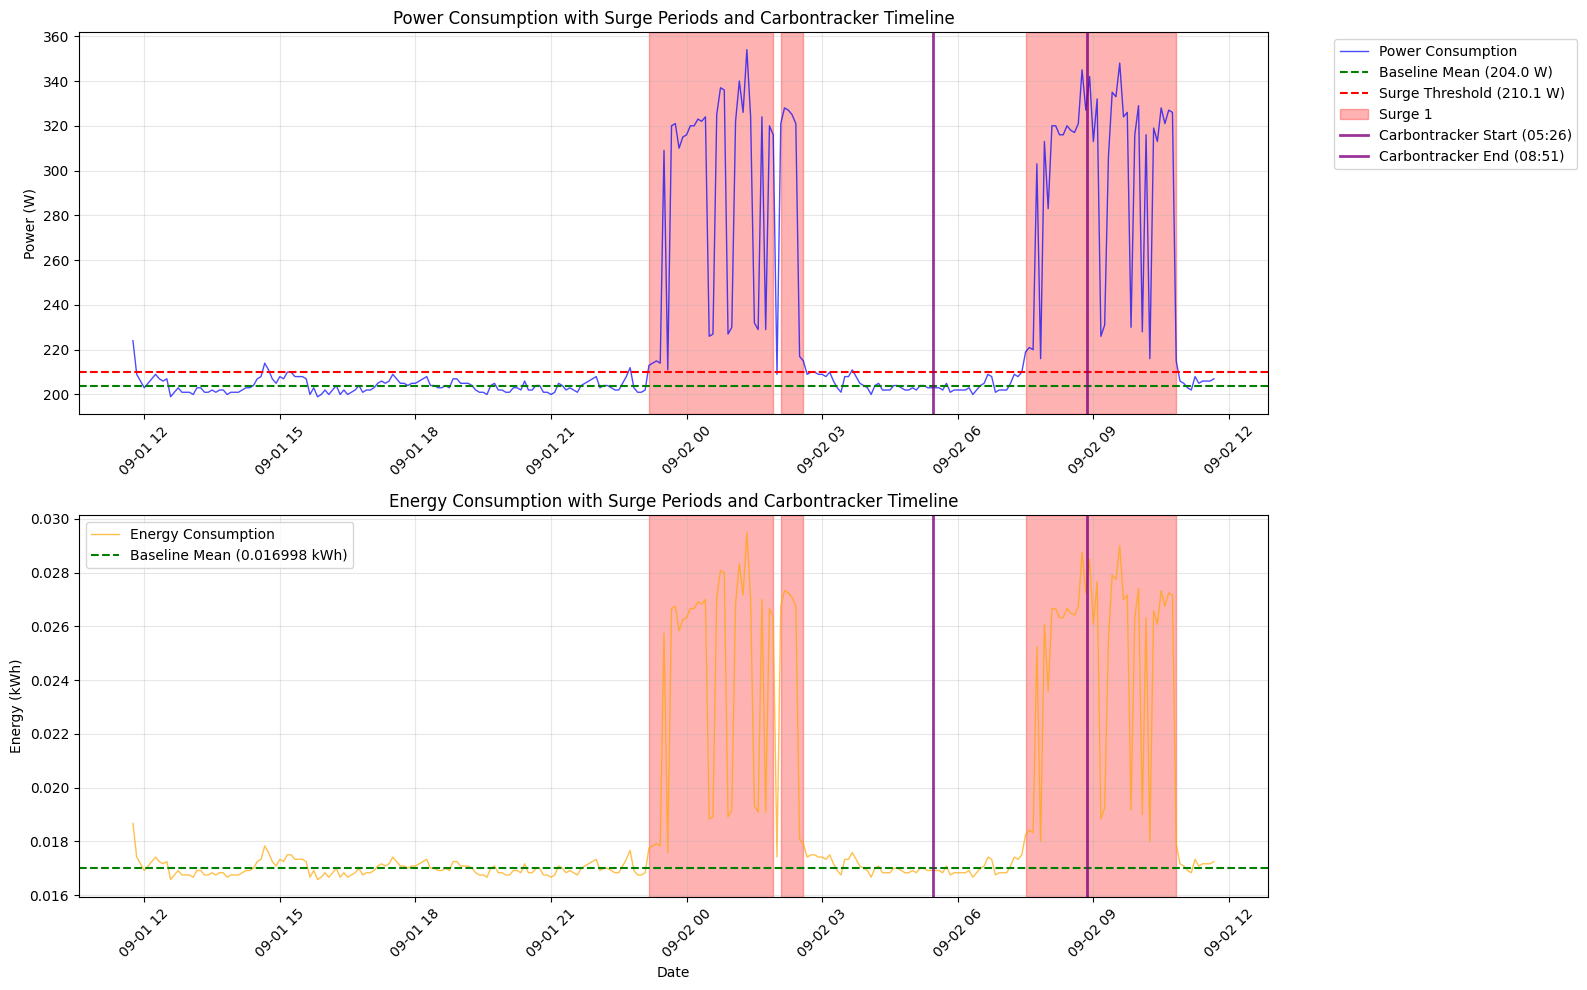

=== CARBONTRACKER vs POWER SURGE ANALYSIS ===
Carbontracker monitoring period: 05:26 - 08:51
Carbontracker duration: 3.41 hours

Overlap analysis with detected surge periods:
  Surge 1: No overlap
    Surge: 23:10 - 01:55
  Surge 2: No overlap
    Surge: 02:05 - 02:35
  Surge 3: 40.7% overlap (81.4/200.0 minutes)
    Surge: 07:30 - 10:50
    Overlap: 07:30 - 08:51

Power statistics during Carbontracker period:
  Average power: 241.1 W
  Peak power: 345.0 W
  Total energy: 0.8239 kWh
  Carbontracker reported energy: 0.3861 kWh
  Energy difference: 0.4379 kWh


In [ ]:
# Step 5: Enhanced Visualization with Surge Periods and Carbontracker Markers

# Convert carbontracker timestamps to datetime and make timezone-naive for comparison
first_start_dt = pd.to_datetime(carbontracker_simpipe_data['start'].iloc[0]).tz_localize(None)
last_stop_dt = pd.to_datetime(carbontracker_simpipe_data['stop'].iloc[-1]).tz_localize(None)

print(f"Carbontracker period: {first_start_dt} to {last_stop_dt}")
print(f"Power data period: {power_data['Date'].min()} to {power_data['Date'].max()}")

# Create the enhanced plot
plt.figure(figsize=(16, 10))

# Main power consumption plot
plt.subplot(2, 1, 1)
plt.plot(power_data['Date'], power_data['Power(W)'], linewidth=1, alpha=0.7, color='blue', label='Power Consumption')

# Add baseline threshold line
plt.axhline(y=baseline_stats['mean_power'], color='green', linestyle='--',
           label=f'Baseline Mean ({baseline_stats["mean_power"]:.1f} W)')
plt.axhline(y=surge_threshold, color='red', linestyle='--',
           label=f'Surge Threshold ({surge_threshold:.1f} W)')

# Highlight surge periods
for i, surge in enumerate(surge_periods):
    plt.axvspan(surge['start_time'], surge['end_time'],
               alpha=0.3, color='red', label=f'Surge {i+1}' if i == 0 else "")

# Add carbontracker start and stop markers
plt.axvline(x=first_start_dt, color='purple', linestyle='-', linewidth=2, alpha=0.8,
           label=f'Carbontracker Start ({first_start_dt.strftime("%H:%M")})')
plt.axvline(x=last_stop_dt, color='purple', linestyle='-', linewidth=2, alpha=0.8,
           label=f'Carbontracker End ({last_stop_dt.strftime("%H:%M")})')

plt.title('Power Consumption with Surge Periods and Carbontracker Timeline')
plt.ylabel('Power (W)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Energy consumption plot
plt.subplot(2, 1, 2)
plt.plot(power_data['Date'], power_data['Energy(kWh)'], linewidth=1, alpha=0.7, color='orange', label='Energy Consumption')

# Add baseline energy line
plt.axhline(y=baseline_stats['mean_energy'], color='green', linestyle='--',
           label=f'Baseline Mean ({baseline_stats["mean_energy"]:.6f} kWh)')

# Highlight surge periods
for i, surge in enumerate(surge_periods):
    plt.axvspan(surge['start_time'], surge['end_time'],
               alpha=0.3, color='red')

# Add carbontracker start and stop markers
plt.axvline(x=first_start_dt, color='purple', linestyle='-', linewidth=2, alpha=0.8)
plt.axvline(x=last_stop_dt, color='purple', linestyle='-', linewidth=2, alpha=0.8)

plt.title('Energy Consumption with Surge Periods and Carbontracker Timeline')
plt.ylabel('Energy (kWh)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Analysis of carbontracker period vs power surges
print("=== CARBONTRACKER vs POWER SURGE ANALYSIS ===")
print(f"Carbontracker monitoring period: {first_start_dt.strftime('%H:%M')} - {last_stop_dt.strftime('%H:%M')}")
carbontracker_duration = (last_stop_dt - first_start_dt).total_seconds() / 3600
print(f"Carbontracker duration: {carbontracker_duration:.2f} hours")

# Check overlap with surge periods
print(f"\nOverlap analysis with detected surge periods:")
for i, surge in enumerate(surge_periods, 1):
    surge_start = surge['start_time']
    surge_end = surge['end_time']

    # Check if there's overlap
    overlap_start = max(first_start_dt, surge_start)
    overlap_end = min(last_stop_dt, surge_end)

    if overlap_start < overlap_end:
        overlap_duration = (overlap_end - overlap_start).total_seconds() / 60
        surge_duration = surge['duration_minutes']
        overlap_percentage = (overlap_duration / surge_duration) * 100
        print(f"  Surge {i}: {overlap_percentage:.1f}% overlap ({overlap_duration:.1f}/{surge_duration:.1f} minutes)")
        print(f"    Surge: {surge_start.strftime('%H:%M')} - {surge_end.strftime('%H:%M')}")
        print(f"    Overlap: {overlap_start.strftime('%H:%M')} - {overlap_end.strftime('%H:%M')}")
    else:
        print(f"  Surge {i}: No overlap")
        print(f"    Surge: {surge_start.strftime('%H:%M')} - {surge_end.strftime('%H:%M')}")

# Calculate energy during carbontracker period
ct_mask = (power_data['Date'] >= first_start_dt) & (power_data['Date'] <= last_stop_dt)
ct_power_data = power_data[ct_mask]

if len(ct_power_data) > 0:
    ct_total_energy = ct_power_data['Energy(kWh)'].sum()
    ct_avg_power = ct_power_data['Power(W)'].mean()
    ct_peak_power = ct_power_data['Power(W)'].max()

    print(f"\nPower statistics during Carbontracker period:")
    print(f"  Average power: {ct_avg_power:.1f} W")
    print(f"  Peak power: {ct_peak_power:.1f} W")
    print(f"  Total energy: {ct_total_energy:.4f} kWh")
    print(f"  Carbontracker reported energy: {carbontracker_simpipe_data['energy'].sum():.4f} kWh")

    energy_diff = abs(ct_total_energy - carbontracker_simpipe_data['energy'].sum())
    print(f"  Energy difference: {energy_diff:.4f} kWh")
else:
    print(f"\nNo power data available during Carbontracker period")
    print(f"  Power data range: {power_data['Date'].min()} to {power_data['Date'].max()}")
    print(f"  Carbontracker range: {first_start_dt} to {last_stop_dt}")

In [ ]:
# Step 6: Time Difference Analysis between Power Surges and Carbontracker

print("=== TIME DIFFERENCE ANALYSIS ===")
print(f"Carbontracker start time: {first_start_dt}")
print(f"Carbontracker stop time: {last_stop_dt}")
print()

# Calculate differences for each surge
for i, surge in enumerate(surge_periods, 1):
    surge_start = surge['start_time']
    surge_end = surge['end_time']

    # Time differences in seconds (positive = surge comes after carbontracker)
    start_diff_seconds = (surge_start - first_start_dt).total_seconds()
    end_diff_seconds = (surge_end - last_stop_dt).total_seconds()

    # Convert to hours and minutes for readability
    start_diff_hours = start_diff_seconds / 3600
    end_diff_hours = end_diff_seconds / 3600

    print(f"Surge {i}:")
    print(f"  Surge start: {surge_start}")
    print(f"  Surge end: {surge_end}")
    print(f"  Start time difference from carbontracker start:")
    if start_diff_seconds >= 0:
        print(f"    +{abs(start_diff_hours):.2f} hours ({abs(start_diff_seconds/60):.1f} minutes) AFTER carbontracker start")
    else:
        print(f"    -{abs(start_diff_hours):.2f} hours ({abs(start_diff_seconds/60):.1f} minutes) BEFORE carbontracker start")

    print(f"  End time difference from carbontracker stop:")
    if end_diff_seconds >= 0:
        print(f"    +{abs(end_diff_hours):.2f} hours ({abs(end_diff_seconds/60):.1f} minutes) AFTER carbontracker stop")
    else:
        print(f"    -{abs(end_diff_hours):.2f} hours ({abs(end_diff_seconds/60):.1f} minutes) BEFORE carbontracker stop")
    print()

# Summary of timing relationships
print("=== TIMING RELATIONSHIPS SUMMARY ===")
surges_before_ct = sum(1 for surge in surge_periods if surge['start_time'] < first_start_dt)
surges_during_ct = sum(1 for surge in surge_periods
                      if surge['start_time'] <= last_stop_dt and surge['end_time'] >= first_start_dt)
surges_after_ct = sum(1 for surge in surge_periods if surge['start_time'] > last_stop_dt)

print(f"Surges starting before carbontracker         : {surges_before_ct}")
print(f"Surges overlapping with carbontracker period : {surges_during_ct}")
print(f"Surges starting after carbontracker          : {surges_after_ct}")

# Check which surge is closest to carbontracker start
closest_start_surge = None
min_start_diff = float('inf')

for i, surge in enumerate(surge_periods, 1):
    start_diff = abs((surge['start_time'] - first_start_dt).total_seconds())
    if start_diff < min_start_diff:
        min_start_diff = start_diff
        closest_start_surge = i

if closest_start_surge:
    closest_surge = surge_periods[closest_start_surge - 1]
    diff_minutes = min_start_diff / 60
    print(f"\nClosest surge to carbontracker start      : Surge {closest_start_surge}")
    print(f"Time difference: {diff_minutes:.1f} minutes")

    # Check if this surge overlaps with carbontracker execution
    if (closest_surge['start_time'] <= last_stop_dt and
        closest_surge['end_time'] >= first_start_dt):
        print("This surge OVERLAPS with carbontracker execution period")
    else:
        print("This surge does NOT overlap with carbontracker execution period")

=== TIME DIFFERENCE ANALYSIS ===
Carbontracker start time: 2025-09-02 05:26:59
Carbontracker stop time: 2025-09-02 08:51:24

Surge 1:
  Surge start: 2025-09-01 23:10:00
  Surge end: 2025-09-02 01:55:00
  Start time difference from carbontracker start:
    -6.28 hours (377.0 minutes) BEFORE carbontracker start
  End time difference from carbontracker stop:
    -6.94 hours (416.4 minutes) BEFORE carbontracker stop

Surge 2:
  Surge start: 2025-09-02 02:05:00
  Surge end: 2025-09-02 02:35:00
  Start time difference from carbontracker start:
    -3.37 hours (202.0 minutes) BEFORE carbontracker start
  End time difference from carbontracker stop:
    -6.27 hours (376.4 minutes) BEFORE carbontracker stop

Surge 3:
  Surge start: 2025-09-02 07:30:00
  Surge end: 2025-09-02 10:50:00
  Start time difference from carbontracker start:
    +2.05 hours (123.0 minutes) AFTER carbontracker start
  End time difference from carbontracker stop:
    +1.98 hours (118.6 minutes) AFTER carbontracker stop

=